<a href="https://colab.research.google.com/github/hongjumeow/GCT634/blob/main/GCT634_HW1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Musical Instrument Recognition  (Single-Label Classification)

# Importing Packages

In [68]:
# load libraries
import sys
import os
import numpy as np
import librosa
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt

# Global Settings

In [ ]:
# download the dataset file
!gdown --id 1rGXx_f-4VlSXJIje7DaCBl38dl14GwWX

In [ ]:
# uncompress the zip file
!unzip gct634_nsynth.zip

In [69]:

# Change this data path with your own local path
data_path = './gct634_nsynth/'

# path to store MFCC
mfcc_path = './nsynth_features/mfcc/'

MFCC_DIM = 15

NUM_TRAIN = 1100 # 1100
NUM_VALID = 300 # 300


flute_acoustic_004-060-100.wav


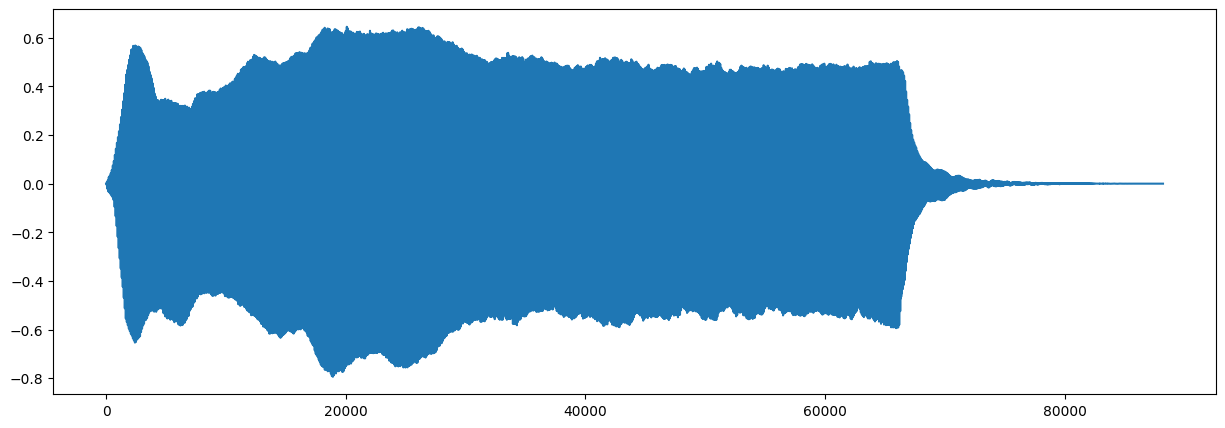

In [70]:
# Check waveform of an audio clip

file_path = './gct634_nsynth/train/'
files = os.listdir(file_path)
y, sr = librosa.load(file_path + files[NUM_TRAIN // 10 * 2])


plt.figure(figsize=(15, 5))
plt.plot(y)
print(files[NUM_TRAIN // 10 * 2])

# Feature Extraction

In [71]:

# Check features before extracting

S = librosa.core.stft(y, n_fft=1024, hop_length=512, win_length=1024)

# power spectrum
D = np.abs(S)**2

# mel spectrogram (512 --> 40)
mel_basis = librosa.filters.mel(sr=sr, n_fft=1024, n_mels=40)
mel_S = np.dot(mel_basis, D)

#log compression
log_mel_S = librosa.power_to_db(mel_S)

# MFCCs
mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=MFCC_DIM)
delta_mfcc = librosa.feature.delta(mfcc)
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

# Spectral Statistics
centroid = librosa.feature.spectral_centroid(S=np.sqrt(D), sr=sr)[0]
bandwidth = librosa.feature.spectral_bandwidth(S=np.sqrt(D), sr=sr)[0]
flatness = librosa.feature.spectral_flatness(S=np.sqrt(D))[0]

# Temporal Envelope
rms = librosa.feature.rms(y=y, frame_length=1024, hop_length=512)[0] # shape: (1, time_frames)

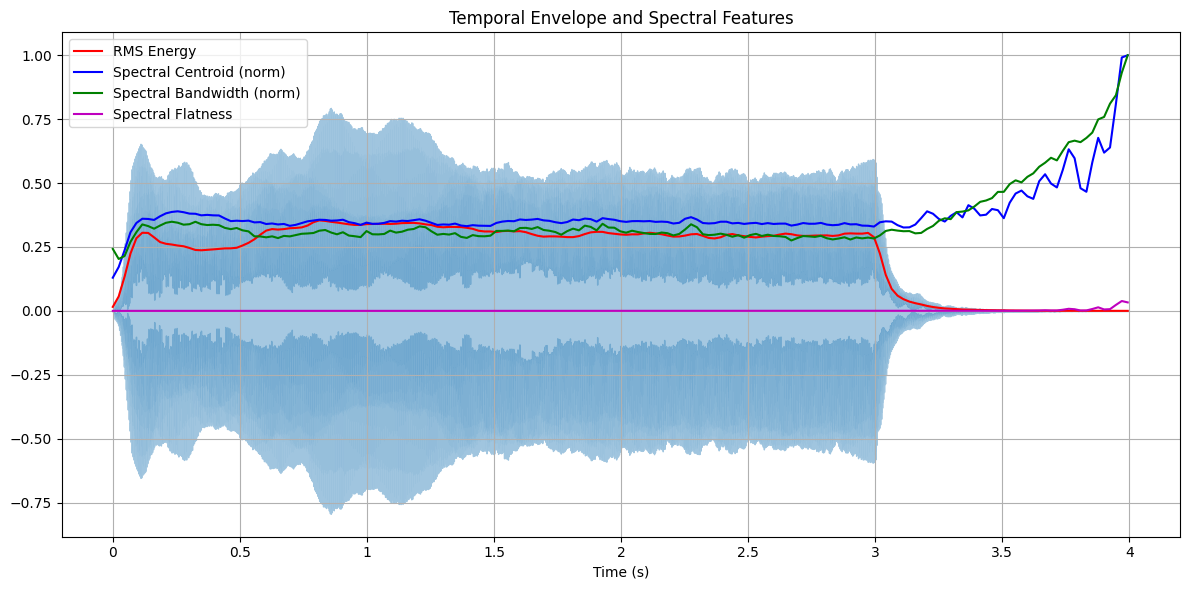

In [72]:

# Plot Spectral and Temporal Features

frames = range(len(rms))
times = librosa.frames_to_time(frames, sr=sr, hop_length=512)


plt.figure(figsize=(12, 6))
librosa.display.waveshow(y, sr=sr, alpha=0.4)
plt.plot(times, rms, label='RMS Energy', color='r')
plt.plot(times, centroid / np.max(centroid), label='Spectral Centroid (norm)', color='b')
plt.plot(times, bandwidth / np.max(bandwidth), label='Spectral Bandwidth (norm)', color='g')
plt.plot(times, flatness, label='Spectral Flatness', color='m')

plt.title('Temporal Envelope and Spectral Features')
plt.xlabel('Time (s)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [73]:
def extract_mfcc(dataset='train'):
    f = open(data_path + dataset + '_list.txt','r')

    i = 0
    for file_name in f:
        # progress check
        i = i + 1
        if not (i % 10):
            if dataset == 'train':
              print("\r {:.2f}%".format(i/NUM_TRAIN*100), end='')
            elif dataset == 'valid':
              print("\r {:.2f}%".format(i/NUM_VALID*100), end='')

        # load audio file
        file_name = file_name.rstrip('\n')
        file_path = data_path + file_name
        y, sr = librosa.load(file_path, sr=22050)
        
        # STFT
        S = librosa.core.stft(y, n_fft=1024, hop_length=512, win_length=1024)

        # power spectrum
        D = np.abs(S)**2

        # mel spectrogram (512 --> 40)
        mel_basis = librosa.filters.mel(sr=sr, n_fft=1024, n_mels=40)
        mel_S = np.dot(mel_basis, D)

        #log compression
        log_mel_S = librosa.power_to_db(mel_S)

        # mfccs (DCT)
        mfcc = librosa.feature.mfcc(S=log_mel_S, n_mfcc=MFCC_DIM)
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
        
        # spectral statistics
        centroid = librosa.feature.spectral_centroid(S=np.sqrt(D), sr=sr)
        bandwidth = librosa.feature.spectral_bandwidth(S=np.sqrt(D), sr=sr)
        flatness = librosa.feature.spectral_flatness(S=np.sqrt(D))

        # temporal envelope
        rms = librosa.feature.rms(y=y, frame_length=1024, hop_length=512)
        
        mfcc = mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
        delta_mfcc = delta_mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
        delta2_mfcc = delta2_mfcc.astype(np.float32)    # to save the memory (64 to 32 bits)
        centroid = centroid.astype(np.float32)    # to save the memory (64 to 32 bits)
        bandwidth = bandwidth.astype(np.float32)    # to save the memory (64 to 32 bits)
        flatness = flatness.astype(np.float32)    # to save the memory (64 to 32 bits)
        rms = rms.astype(np.float32)

        features = np.vstack([
          mfcc,
          delta_mfcc, delta2_mfcc, 
          centroid,
          bandwidth,
          flatness,
          rms,
          ])

        # save feature as a file
        file_name = file_name.replace('.wav','.npy')
        save_file = mfcc_path + file_name

        if not os.path.exists(os.path.dirname(save_file)):
            os.makedirs(os.path.dirname(save_file))
        np.save(save_file, features)

    f.close()

In [55]:
extract_mfcc(dataset='train')
extract_mfcc(dataset='valid')

 100.00%

# Feature Summary

In [ ]:
def mean_mfcc(dataset='train'):

    f = open(data_path + dataset + '_list.txt','r')

    num_mfcc = 3
    num_spectral_features = 3
    num_temporal_features = 1
    num_features = num_mfcc * MFCC_DIM + num_spectral_features + num_temporal_features
    if dataset == 'train':
        feat_mat = np.zeros(shape=(num_features, NUM_TRAIN))
    elif dataset == 'valid':
        feat_mat = np.zeros(shape=(num_features, NUM_VALID))

    i = 0
    for file_name in f:

        # load feature file
        file_name = file_name.rstrip('\n')
        file_name = file_name.replace('.wav','.npy')
        feature_file = mfcc_path + file_name
        feature = np.load(feature_file)
        # mean pooling
        feat_mat[:, i]= np.mean(feature, axis=1)
        i = i + 1

    f.close()

    return feat_mat


In [57]:
train_mfcc = mean_mfcc('train')
valid_mfcc = mean_mfcc('valid')

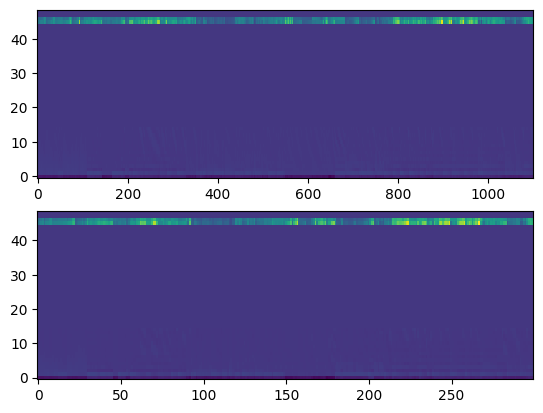

In [58]:
plt.figure(1)
plt.subplot(2,1,1)
plt.imshow(train_mfcc, interpolation='nearest', origin='lower', aspect='auto')

plt.subplot(2,1,2)
plt.imshow(valid_mfcc, interpolation='nearest', origin='lower', aspect='auto')

plt.show()



# Data Preparation

In [59]:
# load data
train_X = train_mfcc
valid_X = valid_mfcc

# label generation
cls = np.array([1,2,3,4,5,6,7,8,9,10])
train_Y = np.repeat(cls, int(NUM_TRAIN/10))
valid_Y = np.repeat(cls, int(NUM_VALID/10))

# feature normalizaiton
train_X = train_X.T
train_X_mean = np.mean(train_X, axis=0)
train_X = train_X - train_X_mean
train_X_std = np.std(train_X, axis=0)
train_X = train_X / (train_X_std + 1e-5)

valid_X = valid_X.T
valid_X = valid_X - train_X_mean
valid_X = valid_X/(train_X_std + 1e-5)


# ML Model Training & Validation

In [60]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [ ]:
# Baseline

def train_model(train_X, train_Y, valid_X, valid_Y, hyper_param1):

    # Choose a classifier (here, linear SVM)
    clf = SGDClassifier(verbose=0, loss="hinge", alpha=hyper_param1, max_iter=1000, penalty="l2", random_state=0)

    # train
    clf.fit(train_X, train_Y)

    # validation
    valid_Y_hat = clf.predict(valid_X)

    accuracy = np.sum((valid_Y_hat == valid_Y))/NUM_VALID*100.0

    return clf, accuracy

In [ ]:
# Implementation: Ensemble

def train_model(train_X, train_Y, valid_X, valid_Y, hyper_param1):

    clf1 = LogisticRegression(C=1.0, max_iter=1000)
    clf2 = RandomForestClassifier()
    clf3 = SVC(probability=True)
    
    voting_clf = VotingClassifier(estimators=[
        ('lr', clf1), ('rf', clf2), ('svc', clf3)
    ], voting='soft')
    
    voting_clf.fit(train_X, train_Y)

    valid_Y_hat = voting_clf.predict(valid_X)

    accuracy = np.sum((valid_Y_hat == valid_Y))/NUM_VALID*100.0

    return voting_clf, accuracy


In [67]:
# training model
alphas = [0.0001, 0.001, 0.01, 0.1, 1]

model = []
valid_acc = []

# model search
for a in alphas:
  clf, acc = train_model(train_X, train_Y, valid_X, valid_Y, a)
  model.append(clf)
  valid_acc.append(acc)

  print(f'alpha={a:.4f}, validation acc={acc:.2f}%')

# choose the model that achieve the best validation accuracy
final_model = model[np.argmax(valid_acc)]

print(f'Best validation acc={valid_acc[np.argmax(valid_acc)]:.2f}%')


alpha=0.0001, validation acc=97.67%
alpha=0.0010, validation acc=97.67%
alpha=0.0100, validation acc=97.67%
alpha=0.1000, validation acc=97.67%
alpha=1.0000, validation acc=97.67%
Best validation acc=97.67%
